# Gaussian Processes Regression

In this notebook, we will implement a Gaussian Processes Regression model from scratch and apply it to solve practical problems. The main objectives are:

1. Understanding how to fit a Gaussian Process Regression model.

2. Investigating how the kernel hyper-parameters can affect the model fitting.

3. Understanding how to select kernel hyper-parameters via *marginal loglikelihood optimisation*.





In [3]:
import torch
import numpy as np
import pandas as pd
from typing import Callable, Optional

import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Important in this tutorial due to numerical precision
torch.set_default_dtype(torch.float64)

### Toy Dataset
***

As a start, we will consider a synthetic dataset consisting of 3 data points of dimension 1, $X = \{x_1, x_2, x_3 \} = \{ -1, 0, 1 \}$, and the response variables $y = \{y_1, y_2, y_3\}$ are generated as follows:
\begin{align*}
  y_i &= f(x_i) = \frac{1}{1 + \exp(- x_i)} - 1 \;.
\end{align*}

toy_y: tensor([-0.7311, -0.5000, -0.2689])


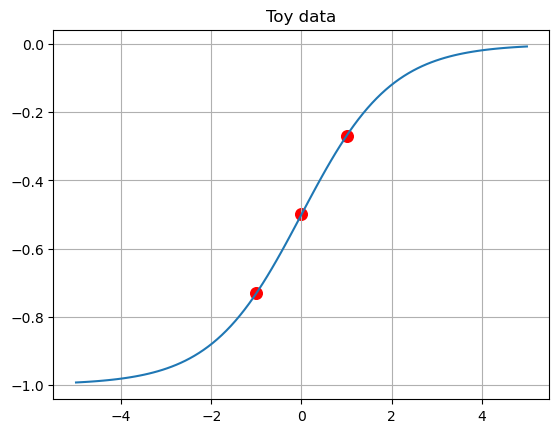

In [4]:
def f(x):
    """
    This function applies the sigmoid function and then subtracts 1.

    Args:
    x (torch.Tensor): Input tensor.

    Returns:
    torch.Tensor: Transformed tensor.
    """
    return 1 / (1 + torch.exp(-x)) - 1


# observed data
toy_X = torch.tensor([-1., 0., 1.])
toy_y = f(toy_X)

print(f"toy_y: {toy_y}")

# Plot observed data
plot_x = torch.linspace(-5., 5., 100)
plt.plot(plot_x.numpy(), f(plot_x).numpy())  # Converting tensors to numpy arrays for plotting
plt.scatter(toy_X.numpy(), toy_y.numpy(), color="red", s=70)
plt.title("Toy data")
plt.grid()
plt.show()

Expected output:
```python
toy_y: tensor([-0.7311, -0.5000, -0.2689])
```

## Specifying a GP Prior
***

Our aim is to approximate the function $f$ by fitting a Gaussian Process. That is, we place a GP prior on $f$ and seek the posterior distribution of $f$ conditional on the observed data.

We will use a **noisy observations** model $y_i = f(x_i) + \epsilon_i$, where $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$ are i.i.d. Gaussian noise with variance $\sigma^2$. Recall the GP model with mean function $m$ and kernel (covariance) function $K$ is,

$$
  f(X) \sim \mathcal{N}(m(X), K(X, X)) \;,
$$

where $X = (x_1, \ldots, x_N)$. Choosing a **zero function** for $m$, the posterior distribution at $M$ new test points $X^* = (x_1^*, \ldots, x_M^*)$ is

$$
\begin{align*}
  f^* | X, \mathbf{y}, X^*
  &\sim \mathcal{N}( \tilde{m} ,\; \tilde{\Sigma} ) \;, \\
  \tilde{m} &= K(X^*, X) [ K(X, X) + \sigma^2 I_n ]^{-1} \mathbf{y}, \\
  \tilde{\Sigma} &= K(X^*, X^*) - K(X^*, X) [K(X, X) + \sigma^2 I_n]^{-1} K(X, X^*) ).
\end{align*}
$$

Remarks:

1. **Zero prior mean:** The choice of $m \equiv 0$ is without loss of generality because we can always center the response variable by subtracting its empirical mean.

2. **Noisy observation model:** We could in principle use a noise-free observation model for this toy dataset. However, using the noisy model allows us to write the code in more generality, which will be helpful when we work with the real-life dataset in the second part of this notebook. Moreover, we will see later how to select the model hyper-parameters using a data-centric approach (i.e., log marginal likelihood maximisation). If the data are indeed generated from a noiseless process, then we should be able to recover the noise-free setting by selecting a very small $\sigma_2$.

For the **kernel function**, we will use the **Squared Exponential** kernel, also known as the **Radial Basis Function** (RBF) kernel. It is one of the most widely used choice of kernel function. Recall from the lecture notes that it is defined as

$$
k(x, x') = \theta_1^2 \exp\left( - \frac{1}{2 \theta_2^2} \| x - x' \|_2^2 \right) \;,
$$

where $\theta_1, \theta_2 > 0$ are hyper-parameters that we need to specify. As we will see, the choice of these kernel hyper-parameters can have significant impact on the model quality. In practice, they are often chosen in a ''data-centric'' mannor, or by domain knowledge of the problem at hand.

For now, we will set $\theta_1, \theta_2 = 1$.

Also note that $d = 1$ in this example, so the squared $l_2$ norm reduces to $(x-x')^2$. But we are going to implement the multidimensional setting.

#### Exercise 1

Implement a RBF kernel by completing the code below.

Your `RBF` class should

1. take as its input two tensors of **potentially different** shapes, e.g., x1.shape = $[n,d]$ and x2.shape = $[m,d]$.

2. output a kernel matrix with appropriate shape, e.g. if x1.shape = $[4,3]$ and x2.shape = $[10,3]$ then $k(x, y)$ is a $4 \times 10$ tensor, where $k(x, y)_{i, j} = k(x_i, y_j)$.

3. Your code should use vectorised operations for fast computation.

In [5]:
# Hint on how to compute ||x1-x2||^2 for x1 with shape (n, d) and x2 with shape (m, d): Use broadcasting! (GOOGLE IT!)
# Expand the tensors to have shape (n, m, d) using unsqueeze (not by repeating it and store the same data).
# You can now subtract them and compute the norm

In [6]:
class Kernel:
  """
  How the kernel classes should look like.
  the __call__ method allows you to call the class as if it were a function. Example:

  >>> ker = Kernel(params)
  >>> result = ker(x1,x2)
  """

  def __init__(self, params : dict):
    pass

  def __call__(self, x1, x2):
    raise NotImplementedError()
  

  # Static method means that it is a normal function, but it is inside the class (no self argument)
  # DO NOT CHANGE THIS METHOD
  @staticmethod
  def check_shapes(x1,x2):
    """
    Checks if the input tensors have the correct shape. If the tensor is 1D, it will be converted to 2D with shape (n,1).
    """
    if len(x1.shape) == 1:
      x1 = x1.unsqueeze(1)
    elif len(x1.shape) > 2:
      raise ValueError("Expected x to be a tensor of dimension 1 or 2, but got {}".format(len(x1.shape)))
    
    if len(x2.shape) == 1:
      x2 = x2.unsqueeze(1)
    elif len(x2.shape) > 2:
      raise ValueError("Expected y to be a tensor of dimension 1 or 2, but got {}".format(len(x2.shape)))
    
    if x1.shape[1] != x2.shape[1]:
      raise ValueError("Expected x and y to have the same number of columns, but got {} and {}".format(x1.shape[1], x2.shape[1]))
    
    return x1,x2


class RBF(Kernel):

    def __init__(self, params : dict):

        # Unpack params
        self.theta1 = params['theta1']
        self.theta2 = params['theta2']

    def set_params(self, params: dict):
        
        self.theta1 = params['theta1']
        self.theta2 = params['theta2']

    def __call__(self, x1, x2):
        """
        Radial Basis Function (RBF) kernel implementation in PyTorch.
        Given an input tensor x of size n and another input tensor y of size m,
        compute the n by m kernel matrix whose (i, j)-th entry is k(x1_i, x2_j).

        Args:
        x1 (torch.Tensor): Input tensor of shape (n, d) where d is the number of dimensions.
        x2 (torch.Tensor): Input tensor of shape (m, d) where d is the number of dimensions.

        Returns:
        torch.Tensor: Kernel matrix of shape (n, m).
        """

        x1, x2 = self.check_shapes(x1, x2)

        # Calculate pairwise squared Euclidean distances
        diff = x1.unsqueeze(1) - x2.unsqueeze(0)  # Broadcasting to get pairwise differences
        squared_diff_matrix = (diff ** 2).sum(dim=-1)

        # Compute the RBF kernel matrix
        k_mat = self.theta1 ** 2 * torch.exp(-1 / (2 * self.theta2 ** 2) * squared_diff_matrix)

        return k_mat


In [7]:
# Testing the rbf kernel
rbf_params_testing = {'theta1': 1., 'theta2': 1.}

rbf_testing = RBF(rbf_params_testing)
rbf_testing(toy_X, toy_X)

tensor([[1.0000, 0.6065, 0.1353],
        [0.6065, 1.0000, 0.6065],
        [0.1353, 0.6065, 1.0000]])

Expected output:
```python
tensor([[1.0000, 0.6065, 0.1353],
        [0.6065, 1.0000, 0.6065],
        [0.1353, 0.6065, 1.0000]])
```

## Gaussian Processes Regression
***

We now implement a GP where the prior mean is assumed to be the **zero function**. The same logic will follow if an arbitrary mean function was used, except that the posterior mean and covariance will take a different form.


#### Exercise 2

Implement a Gaussian Process model by completing the `predict` method below. Your code should

1. Compute the posterior mean 1d-tensor and covariance matrix for a given tensor of test points `x_star`.

Try to use `torch.linalg.solve` to compute something like $X^{-1}y$ or $X^{-1}X^*$. Not sure but it might be faster (and if not you have learned a new way to do it :) )

In [8]:
class GP:
    
    def __init__(self, kernel: Callable):
        """
        Initialize the Gaussian Process (GP) with a specified kernel.

        Args:
        kernel (callable): The kernel function to use in the GP.
        """
        self.k = kernel

    def predict(self, x_star, X=None, y=None, size=1, sigma=0.):
        """
        Given observations (X, y) and test points x_star, fit a GP model
        and draw posterior samples for f(x_star) from the fitted model.

        Args:
        x_star (torch.Tensor): Test points at which predictions will be made.
        X (torch.Tensor): Observed features.
        y (torch.Tensor): Observed response variables.
        size (int): Number of posterior samples to draw.
        sigma (float): Noise level in observations.

        Returns:
        torch.Tensor: Posterior samples for f(x_star).
        """

        # Compute kernel matrices
        k_xs_x   = self.k(x_star, X)       # m x n
        k_x_xs   = k_xs_x.T                # n x m
        k_xs_xs  = self.k(x_star, x_star)  # m x m
        k_x_x    = self.k(X, X)            # n x n
        cov_x_x  = k_x_x + sigma**2 * torch.eye(X.shape[0])  # n x n

        # Compute posterior mean and covariance
        posterior_mean = torch.matmul(k_xs_x, torch.linalg.solve(cov_x_x, y))
        posterior_var = k_xs_xs - torch.matmul(k_xs_x, torch.linalg.solve(cov_x_x, k_x_xs))

        # -----------------------------------------------------------------------------------
        # Enforce symmetry and positive definiteness that may be lost due to numerical errors
        posterior_var = (posterior_var + posterior_var.T) / 2  # Enforce symmetry
        # Add a small amount of noise to the diagonal to make the covariance matrix positive definite
        posterior_var = posterior_var + 1e-6 * torch.eye(posterior_var.shape[0])
        # -----------------------------------------------------------------------------------
        
        self.posterior_mean = posterior_mean
        self.posterior_var = posterior_var

        # Draw samples from the posterior distribution
        y_star = torch.distributions.MultivariateNormal(posterior_mean, posterior_var).sample((size,))

        return y_star

In [9]:
# Instantiate GP model
gp_testing = GP(kernel=rbf_testing)

# Initialise test points
toy_xp = torch.linspace(-3., 3., 51)

# Kernel hyper-params
sigma = 0.

# Set seed for reproducibility
torch.manual_seed(123)

# Compute posterior samples
yp = gp_testing.predict(x_star=toy_xp, X=toy_X, y=toy_y, size=100, sigma=0.0)

print(yp.shape)
print(yp[0,:9])

torch.Size([100, 51])
tensor([0.7945, 0.7716, 0.7394, 0.6978, 0.6462, 0.5836, 0.5101, 0.4201, 0.3164])


Expected output:
```python
torch.Size([100, 51])
tensor([0.7945, 0.7716, 0.7394, 0.6978, 0.6462, 0.5836, 0.5101, 0.4201, 0.3164])
```

 We now fit a GP model on our observations. For the hyper-parameters $\theta = (\theta_1, \theta_2)$ of the RBF kernel, we choose arbitrarily $\theta_1 = \theta_2 = 1$. We will discuss the effect of different values on the fitted result in the next section.

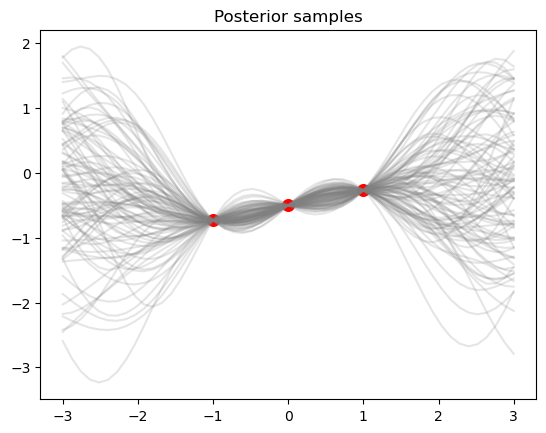

In [10]:
# Plot posterior draws and observations
fig = plt.figure()
plt.plot(toy_xp.numpy(), yp.T.numpy(), color="grey", alpha=0.2)
plt.scatter(toy_X, toy_y, color="red", s=70)
plt.title("Posterior samples")
plt.show()

## Effect of Kernel Hyper-Parameters
***

The choice of the kernel hyper-parameters can often have significant consequences on the fitted GP. 

In [11]:
# ---------------------------------------------------------------------------------
# UTILS FUNCTIONS FOR PLOTTING DO NOT CHANGE - unless you know what you are doing
# Have a look at them to learn how to plot in python!!
# ---------------------------------------------------------------------------------

def plot_varying_theta(theta1_list : Optional = None, 
                       theta2_list : Optional = None, 
                       theta1_fixed : float = 1., 
                       theta2_fixed : float = 1.,):
    """
    Plot posterior draws from GPs fitted with different theta1 and
    fixed theta2.

    Args:
    theta1_list (list): List of theta1 values to use for the RBF kernel.
    theta2 (float): The fixed value of theta2 for the RBF kernel.
    toy_X (torch.Tensor): Observed features.
    toy_y (torch.Tensor): Observed response variables.
    toy_xp (torch.Tensor): Test points at which predictions will be made.
    """
    nrow = 2
    ncol = 3

    if theta1_list is None and theta2_list is None:
        raise ValueError("At least one of theta1_list and theta2_list must be specified.")

    if theta1_list is not None:

        print('=' * 80)
        print("Varying theta1 and fixing theta2 to {}".format(theta2_fixed))
        print('=' * 80)

        fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(12, 8))

        for i, theta1 in enumerate(theta1_list):

            params = {'theta1': theta1, 'theta2': theta2_fixed}
            rbf = RBF(params)
            gp = GP(kernel=rbf)
            yp = gp.predict(x_star=toy_xp, X=toy_X, y=toy_y, size=100, sigma=0.1)

            yp = yp.detach().numpy()  # Convert to numpy for plotting
            axes[i // ncol][i % ncol].plot(toy_xp.numpy(), yp.T, color="grey", alpha=0.2)
            axes[i // ncol][i % ncol].scatter(toy_X.numpy(), toy_y.numpy(), color="red", s=70)
            axes[i // ncol][i % ncol].set_xlim(-3., 3.)
            axes[i // ncol][i % ncol].set_ylim(-20., 20.)
            axes[i // ncol][i % ncol].set_title(f"theta1 = {theta1}")

        plt.tight_layout()
        plt.show()

    # ---------------------------------------------------------------------------------
        
    if theta2_list is not None:

        print('=' * 80)
        print("Varying theta2 and fixing theta1 to {}".format(theta1_fixed))
        print('=' * 80)
        
        fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(12, 8))

        for i, theta2 in enumerate(theta2_list):

            params = {'theta1': theta1_fixed, 'theta2': theta2}
            rbf = RBF(params)
            gp = GP(kernel=rbf)
            yp = gp.predict(x_star=toy_xp, X=toy_X, y=toy_y, size=100, sigma=0.1)

            yp = yp.detach().numpy()  # Convert to numpy for plotting
            axes[i // ncol][i % ncol].plot(toy_xp.numpy(), yp.T, color="grey", alpha=0.2)
            axes[i // ncol][i % ncol].scatter(toy_X.numpy(), toy_y.numpy(), color="red", s=70)
            axes[i // ncol][i % ncol].set_xlim(-3., 3.)
            axes[i // ncol][i % ncol].set_ylim(-10., 10.)
            axes[i // ncol][i % ncol].set_title(f"theta2 = {theta2}")

        plt.tight_layout()
        plt.show()


def interactive_plot1(theta1, theta2):
    """
    Plot posterior draws from GPs fitted with specified theta1 and theta2.

    Args:
    theta1 (float): Value of theta1 for the RBF kernel.
    theta2 (float): Value of theta2 for the RBF kernel.
    toy_X (torch.Tensor): Observed features.
    toy_y (torch.Tensor): Observed response variables.
    toy_xp (torch.Tensor): Test points at which predictions will be made.
    """

    params = {'theta1': theta1, 'theta2': theta2}
    rbf = RBF(params)
    gp = GP(kernel=rbf)
    yp = gp.predict(x_star=toy_xp, X=toy_X, y=toy_y, size=100, sigma=0.1)

    yp = yp.detach().numpy()  # Convert to numpy for plotting
    plt.figure(figsize=(8, 6))
    plt.plot(toy_xp.numpy(), yp.T, color="grey", alpha=0.2)
    plt.scatter(toy_X.numpy(), toy_y.numpy(), color="red", s=70)
    plt.xlim(-3., 3.)
    plt.ylim(-20., 20.)
    plt.title(f"theta1 = {round(theta1,4)}, theta2 = {round(theta2,4)}")
    plt.show()

# Assuming toy_X, toy_y, and toy_xp are predefined tensors
theta1_slider = widgets.FloatLogSlider(
    value=1.0, 
    base=10,
    min=np.log10(0.1),  # min value (log scale)
    max=np.log10(20),   # max value (log scale)
    step=0.1, 
    description='Theta1:')

theta2_slider = widgets.FloatLogSlider(
    value=1.0, 
    base=10,
    min=np.log10(0.1),  # min value (log scale)
    max=np.log10(20),   # max value (log scale)
    step=0.1, 
    description='Theta2:')

Varying theta1 and fixing theta2 to 1.0


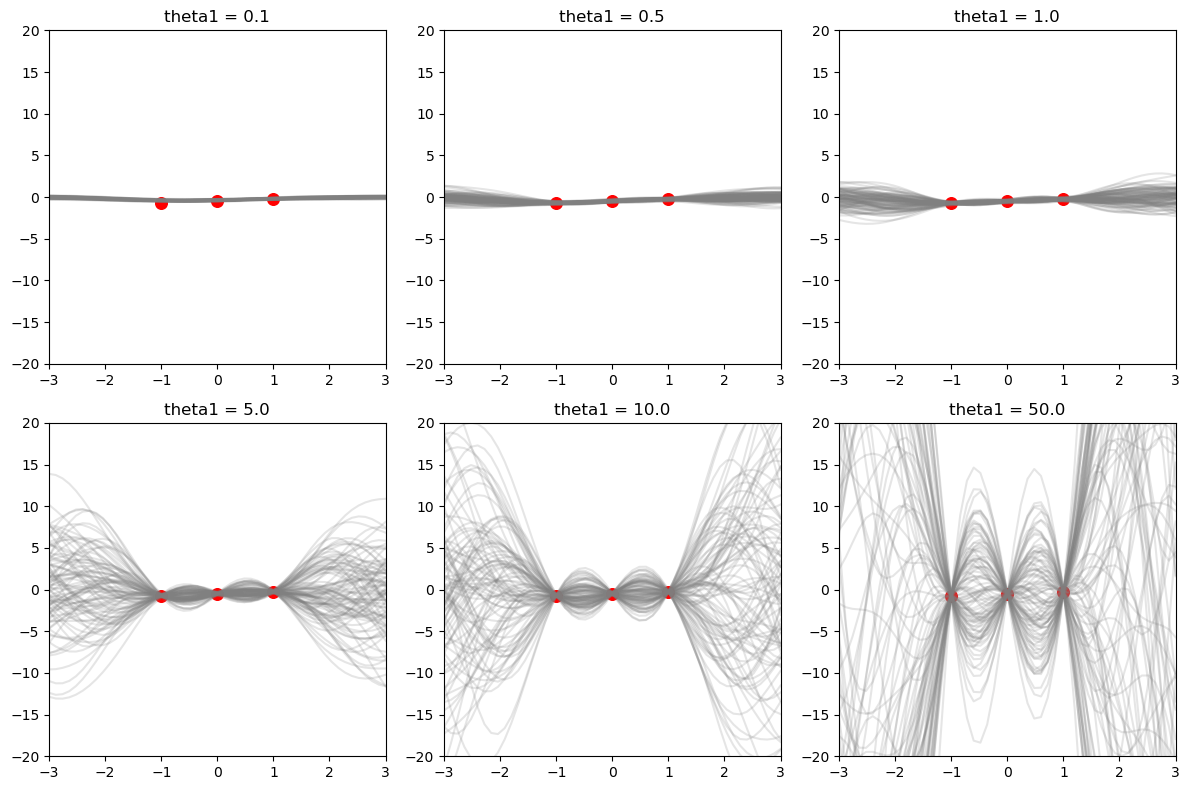

Varying theta2 and fixing theta1 to 1.0


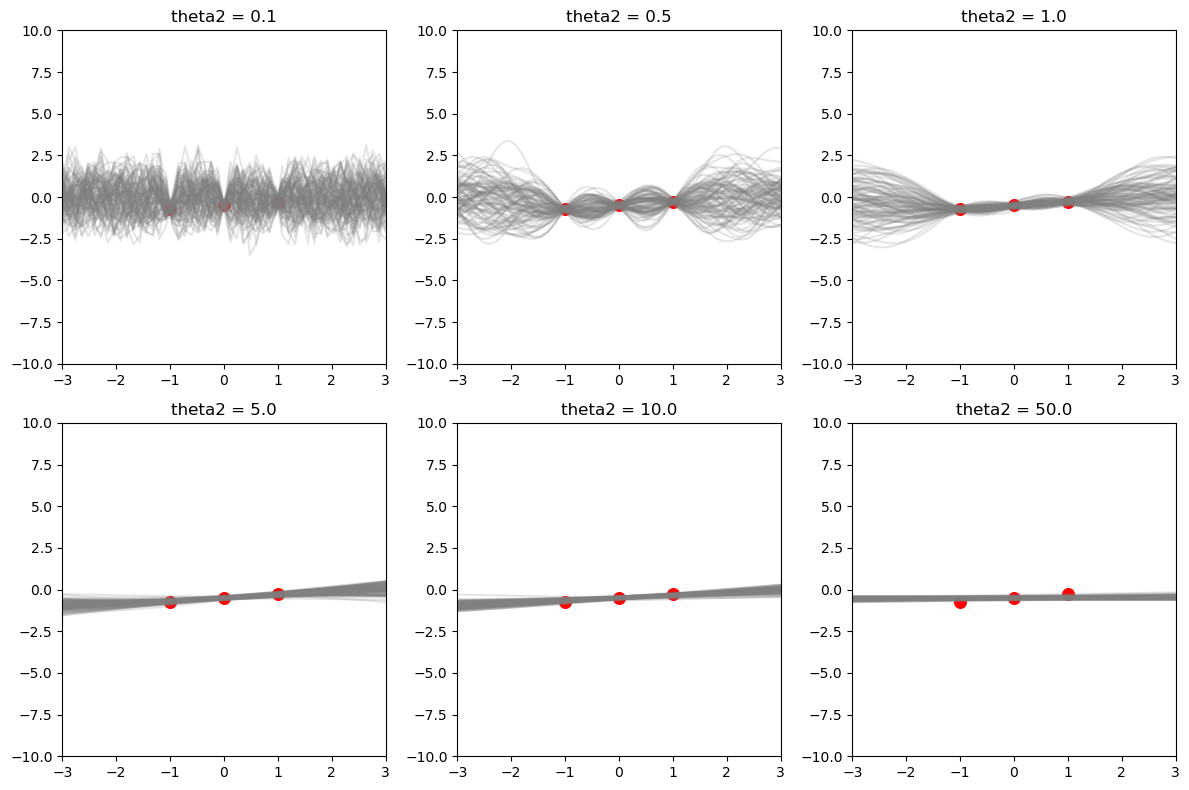

In [12]:
# Plotting
theta1_list = np.array([0.1, 0.5, 1., 5., 10., 50.])
theta2_list = np.array([0.1, 0.5, 1., 5., 10., 50.])

plot_varying_theta(theta1_list=theta1_list, theta2_list=theta2_list)

In [13]:
# Interactive plot
widgets.interactive(interactive_plot1, theta1=theta1_slider, theta2=theta2_slider)

interactive(children=(FloatLogSlider(value=1.0, description='Theta1:', max=1.3010299956639813, min=-1.0), Floa…

#### Exercise 3
Comment on how these two hyper-parameters affect the posterior samples.

<details><summary>Hint</summary>
<p>

Provide mathematical interpretations by assuming $\sigma = 0$ (i.e., a **noise-free** model) and arguing how the posterior mean and covariance matrix change with $\theta_1$ and $\theta_2$.

</p>
</details>


<details><summary>Solution</summary>
<p>

 **$\theta_1$ is the magnitude and controls the "variability" of the posterior functions** </font>. For a mathematical interpretation, let us assume the noise std $\sigma$ small so that we are in the **noise-free** setting. Recall that the posterior GP then takes the form
\begin{align*}
  f^* | f, X, X^* &\sim \mathcal{N}( \tilde{m} ,\; \tilde{\Sigma} )
  \;, \\
  \tilde{m} &= K(X^*, X) K(X, X)^{-1} f \\
  \tilde{\Sigma} &= K(X^*,X^*)-K(X^*,X)K(X,X)^{-1}K(X,X^*) \;.
\end{align*}
Denote by $k_\theta(x, x')$ the RBF kernel with hyper-parameter $\theta = (\theta_1, \theta_2)$, and similarly define the corresponding covariance matrix $K_\theta$. Also denote by $\tilde{m}_\theta, \tilde{\Sigma}_\theta$ the posterior mean and covariance using kernel $K_\theta$. It is straghtforward to see that $k_{(\theta_1, \theta_2)}(x, x') = \theta_1 k_{(1, \theta_2)} (x, x')$ for any $\theta_1, \theta_2 > 0$. Therefore,
- The posterior mean does **not** depend on $\theta_1$ due to cancellation.
- The posterior covariance function scales linearly with $\theta_1$:
$$
  \tilde{\Sigma}_\theta
  = \theta_1 K_{(1, \theta_2)}(X^*,X^*) - \theta_1 K_{(1, \theta_2)}(X^*,X)K_{(1, \theta_2)}(X,X)^{-1}K_{(1, \theta_2)}(X,X^*)
  = \theta_1 \tilde{\Sigma}_{(1, \theta_2)}
  \;.
$$

Hence, increasing $\theta_1$ does not change the posterior mean but increases the posterior variance. This is evident from the first plot.

 **$\theta_2$ is the length-scale and controls the "wigglyness" of the posterior functions**. Given $x, x' \in \mathbb{R}^d$, if $x = x'$, then the kernel value is $\theta_1$. We suppose $x \neq x'$. If $\theta_2 \ll \| x - x' \|_2$, then the exponent in the RBF kernel will be negatively large, so $k_\theta(x, x')$ will be close to 0. Therefore, the kernel matrix will tend to $\theta_1 I_d$ as $\theta_2$ increases, where $I_d$ is the $d \times d$ identity matrix. It follows that the posterior prediction will tend to a **standard Gaussian distribution**. This is illustrated in the top row of the second plot, where for $\theta_2$ small, the predictions seem to be simply random noises.

On the other hand, if $\theta_2 \gg \| x - x' \|_2$, then $k_\theta(x, x')$ will be close to $\theta_1$ for all $x \neq x'$, and the kernel matrix will tend to a **degenerate** matrix where each entry equals to $\theta_1$. This suggests a almost perfect correlation between the predicted values at every test point. This is illustrated by the bottom row of the second plot, where for $\theta_2$ large the posterior samples have almost no variation amongst its posterior mean.

In general, a large $\theta_2$ is suitable for capturing **long-term** trend in $x$, whilst a small $\theta_2$ is often used for modelling **short-term** effects.

<p>
</details>


## Model Selection
***

One famous approach to optimise the hyper-parameters in a GP model is by maximising the so-called **marginal likelihood** (also known as **evidence**), $p(y | X)$. 

It is defined as the following integral of the likelihood multiplied by the prior:

$$
  p(y | X) = \int p(y | f, X) p(f | X) df \;.
$$

The term **marginal** refers to the marginalisation over the functions $f$. Under a GP model, the prior is Gaussian, $f | X \sim \mathcal{N}(0, K)$, so

$$
  \log p(f | X) = -\frac{1}{2} f^\top K(X, X)^{-1} f - \frac{1}{2} \log | K(X, X) | - \frac{n}{2} \log2 \pi \;.
$$

Under the noisy observation assumption, $y_i = f(x_i) + \epsilon$ where $\epsilon \sim \mathcal{N}(0, \sigma^2)$, so the likelihood is a factorised Gaussian $y | f, X \sim \mathcal{N}(f(X), \sigma^2 I_n)$.

Using the fact that the product of Gaussians is still a Gaussian (see lecture notes), we conclude (**exercise**):

$$
\begin{align*}
  \log p(y | X) = - \frac{1}{2} y^\top (K(X, X) + \sigma^2 I_n)^{-1} y - \frac{1}{2} \log | K(X, X) + \sigma^2 I_n | - \frac{n}{2} \log 2\pi \;.
\end{align*}
$$

We call the above equation the **log marginal likelihood**.
<!-- To emphasize its dependence on the hyper-parameters $\theta$ and $\sigma$, we also write $\log p(y | X, \theta, \sigma)$.  -->

The three terms here have intuitive roles:
- $- \frac{1}{2} y^\top (K(X, X) + \sigma^2 I_n)^{-1} y$ is the **data fit** and is the only term involving the observed targets $y$.

- $\log | K(X, X) + \sigma^2 I_n |$ is the **complexity penalty** that depends only on the input $X$ and kernel fuction.

- $\frac{n}{2} \log 2\pi$ is a **normalising constant** that does not depend on the hyper-parameters $\theta$ nor $\sigma$, so it can be ignored when performing optimisation.

**DO NOT USE THIS NORMALISING CONSTANT IN THE EXERCISE (OR YOU WILL GET DIFFERENT VALUES)**


#### Exercise 4
Implement the log marginal likelihood by completing the `marginal_loglik` method in the `GP` class defined in the previous section.
- Your code should be numerically stable. You might find `torch.linalg.slogdet` useful. 

In [14]:
# Not a vary nice way to add a method to a class but for now it works

class GP(GP):
    
    def __init__(self, kernel: callable):
        """
        Initialize the Gaussian Process (GP) with a specified kernel.

        Args:
        kernel (callable): The kernel function to use in the GP.
        """
        self.k = kernel

    def marginal_loglik(self, X, y, sigma=0.):
        """
        Compute the marginal log likelihood of a GP model given observations.

        Args:
        X (torch.Tensor): Observed features.
        y (torch.Tensor): Observed response variables.
        theta (list): Kernel hyperparameters.
        sigma (float): Noise level in observations.

        Returns:
        float: Marginal log likelihood of the GP model.
        """

        # Compute kernel matrix
        k_x_x = self.k(X, X)  # n x n
        cov_x_x = k_x_x + sigma**2 * torch.eye(X.size(0))  # n x n

        data_fit = -0.5 * y.t() @ torch.linalg.solve(cov_x_x, y)
        _, log_det = torch.linalg.slogdet(cov_x_x)
        penalty = -0.5 * log_det

        log_lik = data_fit + penalty 

        return log_lik

In [15]:
# Testing
gp_testing = GP(kernel=rbf_testing)

gp_testing.marginal_loglik(X=toy_X, y=toy_y, sigma=sigma)

tensor(0.2478)

Expected output:
```python
tensor(0.2478)

```

To find the best hyper-parameters, we seek the **partial derivatives** of the marginal loglikelihood with respect to $\theta$ and $\sigma$, i.e., $\frac{\partial}{\partial \theta_j} \log p(y | X) $ and $\frac{\partial}{\partial \sigma} \log p(y | X) $. This can be done by either manually computing these derivatives, or using **auto-differentiation**.

In this notebook, we will use [**auto-differentiation**](https://en.wikipedia.org/wiki/Automatic_differentiation) and the optimisation algorithm Adam to perform the hyper-parameter search. 

Since our aim is to **maximise** the log marginal likelihood, we will set the objective function to be the **negative log marginal likelihood**. 

#### Excercise 5

Implement the optimizisation loop. You might want to google how torch.optim class works.

In [16]:
def optim_hyperparams(gp, init_params, data_X, data_y, maxiter=60, learning_rate=0.02):
    """
    Optimize the hyperparameters of a Gaussian Process model to maximize the 
    log marginal likelihood. This function uses gradient descent with the Adam 
    optimizer to iteratively adjust the hyperparameters.

    Args:
    gp (GP): An instance of the Gaussian Process model.
    init_params (dict): A dictionary containing initial values of hyperparameters.
                        The keys should include 'sigma' and other parameters required by the kernel.
    data_X (torch.Tensor): Input features as a torch.Tensor.
    data_y (torch.Tensor): Output/target values as a torch.Tensor.
    maxiter (int, optional): The number of iterations for the optimization process. Default is 60.
    learning_rate (float, optional): The learning rate for the Adam optimizer. Default is 0.02.

    Returns:
    dict: A dictionary containing:
          - 'optimized_params': Hyperparameters that resulted in the maximum log likelihood.
          - 'max_log_likelihood': The maximum log likelihood value achieved during optimization.
          - 'log_likelihood_history': A list of log likelihood values over iterations.
          - 'params_history': A dictionary mapping each hyperparameter to a list of its values over iterations.
    """

    assert isinstance(init_params, dict), "init_params must be a dictionary."
    assert 'sigma' in init_params.keys(), 'sigma must be in init_params'

    # Flatten all parameters into a single tensor
    params_tensor = torch.tensor([init_params[key] for key in sorted(init_params.keys())],
                                 dtype=torch.float64, requires_grad=True)


    log_likelihood_history = []
    params_history = []

    # Use PyTorch optimizer
    optimizer = torch.optim.Adam([params_tensor], lr=learning_rate)

    for _ in range(maxiter):

        # Set gradients to zero
        optimizer.zero_grad()

        # Update kernel parameters
        updated_params = {key: val for key, val in zip(sorted(init_params.keys()), params_tensor)}
        gp.k.set_params(updated_params)

        # Compute NEGATIVE log likelihood
        neg_log_likelihood = -gp.marginal_loglik(data_X, data_y, sigma=updated_params['sigma'])

        log_likelihood_history.append(-neg_log_likelihood.item())
        params_history.append(params_tensor.clone().detach())  # Store a copy of the current parameters

        # Perform backpropagation
        neg_log_likelihood.backward()

        # Update parameters using step method
        optimizer.step()

    # Extract the optimized parameters and the corresponding log likelihood if they happen before maxiter
    max_log_likelihood_idx = torch.argmax(torch.tensor(log_likelihood_history)).item()  
    max_log_likelihood = max(log_likelihood_history)  
    optimal_params_tensor = params_history[max_log_likelihood_idx]

    params_history = torch.stack(params_history).transpose(0, 1)
    params_history = {key: val for key, val in zip(sorted(init_params.keys()), params_history)}

    # Return the optimized parameters
    optimized_params = {key: val.item() for key, val in zip(sorted(init_params.keys()), optimal_params_tensor)}


    return {'optimized_params': optimized_params, 'max_log_likelihood': max_log_likelihood,
            'log_likelihood_history': log_likelihood_history, 'params_history': params_history}


def plot_likelihood_history(loss_history):
    """
    Plot the history of the log marginal likelihood.

    Args:
    loss_history (list): List of negative log marginal likelihood values.
    """
    plt.plot(loss_history)
    plt.xlabel("Iterations")
    plt.ylabel("Log Marginal Likelihood")
    plt.title("Marginal Log-Likelihood History")
    plt.grid()
    plt.show()

We set the initial set of values for the optimiser to be $\theta^{(0)} = (1, 1)$ and $\sigma^{(0)} = 0.1$. Note that the CG method (and in general most optimisation algorithms) can be **very sensitive** to the starting point.

Max Log-Likelihood: 4.003553746862131
Optimized parameters:
{'sigma': 0.00033559043304941336, 'theta1': 1.0428677465903522, 'theta2': 7.294121488531931}


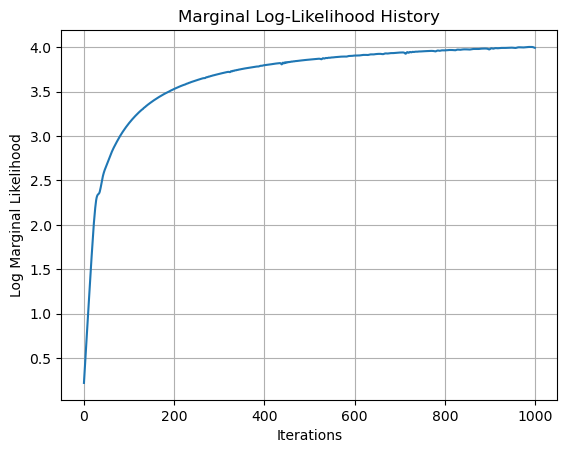

In [17]:
init_params = {'theta1': 1., 'theta2': 1., 'sigma': 0.1}
optimisation_results1 = optim_hyperparams(init_params=init_params, data_X=toy_X, data_y=toy_y, gp=gp_testing, maxiter=1000)

# Dislay the optimized parameters
print('='*100)
print("Max Log-Likelihood: {}".format(optimisation_results1['max_log_likelihood']))
print("Optimized parameters:")
print(optimisation_results1['optimized_params'])
print('='*100)

# Plot
plot_likelihood_history(optimisation_results1['log_likelihood_history'])

## Mauna Loa Atmospheric $\textrm{CO}_2$ Data
***

In the second part of this notebook, we will apply our GP model to a real-life dataset concerning the concentration of $\textrm{CO}_2$. The [Mauna Loa Atmospheric $\textrm{CO}_2$ dataset](https://gml.noaa.gov/ccgg/trends/) consists of concentration of $\textrm{CO}_2$  (in parts per million by volume (ppm)) from the Mauna Loa Observatory from 1958 to 2022. We are interesting in modelling this concentration against time and extrapolating it to future years.

The input $x$ is the observation time (`decimal date`) and the observed target $y$ is the monthly average concentration level (`average`). We aim to fit a **noisy** GP regression model, as we expect the targets are corrupted by noises, potentially due to, e.g., observational error or measurement inaccuracies.

<!-- Note that since this is a time-series data, we expect the observed targets to be **correlated** given test inputs. This renders  -->

### Loading Data

,year,month,decimal date,average,deseasonalized,ndays,sdev,unc
0,1958,3,1958.2027,315.70,314.43,-1,-9.99,-0.99
1,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99
2,1958,5,1958.3699,317.51,314.71,-1,-9.99,-0.99
3,1958,6,1958.4548,317.24,315.14,-1,-9.99,-0.99
4,1958,7,1958.5370,315.86,315.18,-1,-9.99,-0.99


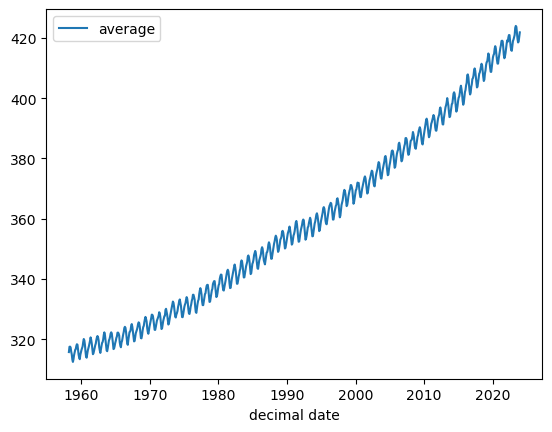

In [18]:
# Download data
url = "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv"
df = pd.read_csv(url, skiprows=40) # skip the first 56 rows containing comments
display(df.head())

# Plot data
df.plot(x="decimal date", y="average")

# Convert data to numpy array
data_X = torch.tensor(df["decimal date"].to_numpy())
data_y = torch.tensor(df["average"].to_numpy())

# Substract empirical mean
data_y -= torch.mean(data_y)

## Specifying Kernel Function
***

We choose as the kernel function a sum of 4 kernel functions that are able to capture different characteristics of the data (recall that sums and products of kernel functions are also kernel functions). Note that we are not claiming this is the best kernel function -- it is entirely possible that other choices are more appropriate for this problem.

1. To model the long-term smooth trend, we use a RBF kernel


$$
k_1(x, x') = \theta_1^2 \exp\left( - \frac{\| x - x' \|_2^2}{2\theta_2^2} \right) \;.
$$


2. To model the periodic behaviour, we use a product of a RBF kernel and a **periodic kernel**, taking the form


$$
k_2(x, x') = \theta_3^2 \exp\left( - \frac{\| x - x' \|_2^2}{2 \theta_4^2} - \frac{2 \sum_{k=1}^d\sin^2( \pi (x_k - x_k') )}{\theta_5^2} \right) \;,
$$


where $\theta_3$ represents the magnitude, $\theta_4$ is the **decay-time** for the periodic component, and $\theta_5$ gives its smoothness. The period (in the argument of $\sin$) has been set to one (year). This is because the seasonal effect is believed to be caused primarily by the different $\textrm{CO}_2$ level uptake for plants depending on the season, although in principle we could have introduced another hyper-parameter to model it completely from the data. **The sum is taken over the dimensions**

3. To model the small/medium-term irregularities, we use a **rational quadratic kernel**


$$
k_3(x, x') = \theta_6^2 \left( 1 + \frac{\| x - x' \|_2^2}{2 \theta_7^2 \theta_8} \right)^{- \theta_8} \;,
$$


where $\theta_6$ gives the magnitude, $\theta_7$ the standard length-scale, and $\theta_8$ the shape parameter. One could have used a RBF kernel for this component. However, since we are interested in modelling the **small/medium** effect, a rational quadratic kernel is a better choice. This is because this kernel decays **polynomially** as a function of $\| x - x'\|_2^2$ (controlled by $\theta_8$), whereas the decay in RBF is exponentially and therefore much faster. This means a rational quadratic kernel can accommodate several length-scales better than a RBF can do.

4. To model the noise term, we use a sum of correlated and uncorrelated components


$$
k_4(x_p, x_q) = \theta_9^2 \exp\left( - \frac{\| x_p - x_q \|_2^2}{2\theta_{10}^2} \right) + \theta_{11}^2 \delta_{pq} \;,
$$


where $\theta_9$ is the magnitude of the correlated component, $\theta_{10}$ the length-scale, and $\theta_{11}$ the magnitude of the uncorrelated component. The correlated term is introduced because the data is a time-series that is believed to suffer from systematic noises (measurement inaccuracies, short-term weather phenomenon etc.). The uncorrelated term serves **exactly the same role as the noise term $\sigma^2 \delta_{pq}$ in a noisy GP model** except a renaming. 

**Therefore, when instantiating $k_4$ in our code we could equivalently only create a RBF kernel with parameters $\theta_9$ and $\theta_{10}$, and the $\theta_{11}$ will be taken over by the `sigma` in `gp.predict`**.

One may also wonder whether the first component in $k_4$ is redundant as it has an identical form as $k_1$. The answer is no -- we will see that after hyper-parameter optimisation one will have a **short length-scale (noise)** and the other a **long length-scale (the long-term signal)**. These two terms are, however, **unidentifiable**, meaning that we may observe $k_1$ to have a long length-scale and the first term in $k_4$ to have a short length-scale, and vice versa. It is only a matter of interpretation that we have chosen to call one the "noise" term and the other the "signal".

These choices are made based on our prior understanding of the data (e.g., by inspecting the data plot). This is often how the kernel function for GPs are consructed in practice, where the practitioner choose a combination of kernels that can model different characteristics of the data. For example, the periodic kernel is used if the data exhibit periodic trend, and the RBF kernel is often the go-to choice to model smooth functions. A survey of well-known kernel functions can be found on this [kernel cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/).



#### Exercise 6
Complete the code below to implement the Periodic kernel and the Rational Quadratic kernel and the 'Sum' Kernel.

In [19]:
class Periodic(Kernel):

    def __init__(self, params: dict):
        self.theta3 = params['theta3']
        self.theta4 = params['theta4']
        self.theta5 = params['theta5']

    def set_params(self, params: dict):
        self.theta3 = params['theta3']
        self.theta4 = params['theta4']
        self.theta5 = params['theta5']

    def __call__(self, x1, x2):
        """
        Compute the periodic kernel matrix.

        Args:
        x1 (torch.Tensor): Input tensor of shape (n, d).
        x2 (torch.Tensor): Input tensor of shape (m, d).

        Returns:
        torch.Tensor: Kernel matrix of shape (n, m).
        """
        x1, x2 = self.check_shapes(x1, x2)

        # Broadcasting to get pairwise differences
        diff = x1.unsqueeze(1) - x2.unsqueeze(0)

        squared_diff_matrix = (diff ** 2).sum(dim=-1)

        k_mat = self.theta3 ** 2 * torch.exp(-1 / (2 * self.theta4 ** 2) * squared_diff_matrix -
                2 * (torch.sin(torch.pi * diff) ** 2).sum(dim=-1) / self.theta5 ** 2)
        
        return k_mat


In [20]:
class RationalQuadratic(Kernel):

    def __init__(self, params: dict):
        self.theta6 = params['theta6']
        self.theta7 = params['theta7']
        self.theta8 = params['theta8']
    
    def set_params(self, params: dict):
        self.theta6 = params['theta6']
        self.theta7 = params['theta7']
        self.theta8 = params['theta8']

    def __call__(self, x1, x2):
        """
        Compute the rational quadratic kernel matrix.

        Args:
        x1 (torch.Tensor): Input tensor of shape (n, d).
        x2 (torch.Tensor): Input tensor of shape (m, d).

        Returns:
        torch.Tensor: Kernel matrix of shape (n, m).
        """
        x1, x2 = self.check_shapes(x1, x2)

        # Broadcasting to get pairwise differences
        diff = x1.unsqueeze(1) - x2.unsqueeze(0)
        squared_diff_matrix = (diff ** 2).sum(dim=-1)

        k_mat = self.theta6 ** 2 * (1 + squared_diff_matrix / (2 * self.theta7 ** 2 * self.theta8)) ** (-self.theta8)
        
        return k_mat


In [21]:
class Sum(Kernel):
    
    def __init__(self, params: dict):

        rbf_params = {p: params[p] for p in ['theta1', 'theta2']}
        periodic_params = {p: params[p] for p in ['theta3', 'theta4', 'theta5']}
        rq_params = {p: params[p] for p in ['theta6', 'theta7', 'theta8']}
        rbf2_params = {key: params[p] for key, p in zip(['theta1', 'theta2'],['theta9', 'theta10'])}

        self.rbf = RBF(rbf_params)
        self.rbf2 = RBF(rbf2_params)
        self.periodic = Periodic(periodic_params)
        self.rq = RationalQuadratic(rq_params)

    def set_params(self, params: dict):
            
        rbf_params = {p: params[p] for p in ['theta1', 'theta2']}
        periodic_params = {p: params[p] for p in ['theta3', 'theta4', 'theta5']}
        rq_params = {p: params[p] for p in ['theta6', 'theta7', 'theta8']}
        rbf2_params = {key: params[p] for key, p in zip(['theta1', 'theta2'],['theta9', 'theta10'])}

        self.rbf.set_params(rbf_params)
        self.rbf2.set_params(rbf2_params)
        self.periodic.set_params(periodic_params)
        self.rq.set_params(rq_params)

    def __call__(self, x1, x2):
        """
        Compute the sum kernel matrix k = k_rbf + k_periodic + k_rq + k_rbf2.

        Args:
        x1 (torch.Tensor): Input tensor of shape (n, d).
        x2 (torch.Tensor): Input tensor of shape (m, d).

        Returns:
        torch.Tensor: Kernel matrix of shape (n, m).
        """
        k_rbf = self.rbf(x1, x2)
        k_periodic = self.periodic(x1, x2)
        k_rq = self.rq(x1, x2)
        k_rbf2 = self.rbf2(x1, x2)

        k_mat = k_rbf + k_periodic + k_rq + k_rbf2
        
        return k_mat


In [22]:
# To test here we are going to use a 2d dataset
toy_X_2d = toy_X.unsqueeze(1).repeat(1, 2)

ker_periodic_testing = Periodic({'theta3': 1., 'theta4': 1., 'theta5': 1.})
ker_rq_testing = RationalQuadratic({'theta6': 1., 'theta7': 1., 'theta8': 1.})
ker_sum_testing = Sum({'theta{}'.format(i): 1. for i in range(1, 11)})

# Testing kernels
print('-'*50)
print('Testing Periodic Kernel')
print(ker_periodic_testing(toy_X_2d, toy_X_2d).shape)
print(ker_periodic_testing(toy_X_2d, toy_X_2d))
print('-'*50)
print('Testing Rational Quadratic Kernel')
print(ker_rq_testing(toy_X_2d, toy_X_2d).shape)
print(ker_rq_testing(toy_X_2d, toy_X_2d))
print('-'*50)
print('Testing Sum Kernel')
print(ker_sum_testing(toy_X_2d, toy_X_2d).shape)
print(ker_sum_testing(toy_X_2d, toy_X_2d))
print('-'*50)

--------------------------------------------------
Testing Periodic Kernel
torch.Size([3, 3])
tensor([[1.0000, 0.3679, 0.0183],
        [0.3679, 1.0000, 0.3679],
        [0.0183, 0.3679, 1.0000]])
--------------------------------------------------
Testing Rational Quadratic Kernel
torch.Size([3, 3])
tensor([[1.0000, 0.5000, 0.2000],
        [0.5000, 1.0000, 0.5000],
        [0.2000, 0.5000, 1.0000]])
--------------------------------------------------
Testing Sum Kernel
torch.Size([3, 3])
tensor([[4.0000, 1.6036, 0.2549],
        [1.6036, 4.0000, 1.6036],
        [0.2549, 1.6036, 4.0000]])
--------------------------------------------------


Expected output:
```python
--------------------------------------------------
Testing Periodic Kernel
torch.Size([3, 3])
tensor([[1.0000, 0.3679, 0.0183],
        [0.3679, 1.0000, 0.3679],
        [0.0183, 0.3679, 1.0000]])
--------------------------------------------------
Testing Rational Quadratic Kernel
torch.Size([3, 3])
tensor([[1.0000, 0.5000, 0.2000],
        [0.5000, 1.0000, 0.5000],
        [0.2000, 0.5000, 1.0000]])
--------------------------------------------------
Testing Sum Kernel
torch.Size([3, 3])
tensor([[4.0000, 1.6036, 0.2549],
        [1.6036, 4.0000, 1.6036],
        [0.2549, 1.6036, 4.0000]])
--------------------------------------------------

## Fitting the Model
***

Let us fit a GP regression model with a set of arbitrarily chosen kernel hyper-parameters.

In [23]:
sample_params = {'theta{}'.format(i): 0.5 for i in range(1, 11)}

sum_kernel = Sum(sample_params)
gp = GP(kernel=sum_kernel)

# predict 20 years into the future
pred_X = torch.arange(data_X.max().item() + 1/12., 2043., step=1/12.)
pred_y = gp.predict(pred_X, data_X, data_y, size=100, sigma=0.01)

In [24]:
def plot_predicted_co2(data_X, data_y, pred_X, pred_y):
    """
    Plotting util for CO2 predictions.
    """
    fig = plt.figure()
    plt.plot(data_X.numpy(), data_y.numpy(), color='blue', label="observed")
    plt.plot(pred_X.numpy(), np.transpose(pred_y.numpy()), label="predicted", color="cyan", alpha=0.2)
    plt.xlabel("Year")
    plt.ylabel("Predicted concentration (centred)")
    plt.grid()
    plt.show()

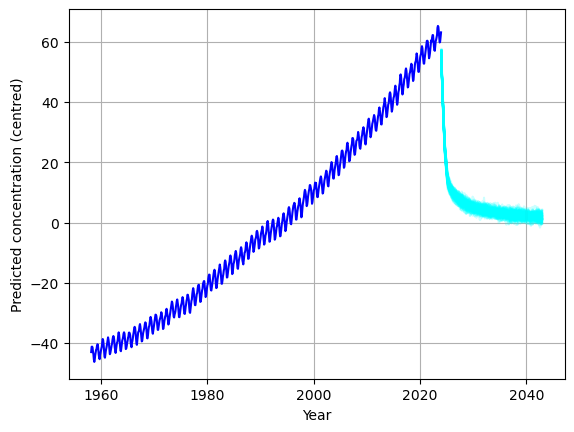

In [25]:
# Posterior predictions with non optimal params
plot_predicted_co2(data_X, data_y, pred_X, pred_y)

Let us now optimise the kernel hyper-parameters to improve the model fitting.

The final hyper-parameter values above are only a **local** optima, since the objective function is highly likely to be **multi-modal** (it is defined on a 11-dimensional space!). One way to accommodate this is to **try multiple starting points** for the optimisation algorithm, and select the one that gives the highest log marginal likelihood.

We use 10 sets of initial values, and find the best hyper-parameters in the 10 runs. We could randomly generate these values from some given intervals, as usually done in practice. However, this will take an long time. For the sake of this tutorial, we generate initial values **close to a set of local optima** reported in Rasmussen CE. Gaussian processes in machine learning. InSummer school on machine learning 2003 Feb 2 (pp. 63-71). Springer, Berlin, Heidelberg..

In [38]:
def optim_hyperparams_multiple_runs(init_params_list, data_X, data_y, gp, maxiter=60, learning_rate=0.02):
    """
    Perform hyperparameter optimization for a Gaussian Process model multiple times, each with 
    different initial hyperparameters. This function is useful for exploring the hyperparameter 
    space more thoroughly and finding a set of hyperparameters that maximizes the log marginal likelihood.

    Args:
    init_params_list (list of dicts): A list of dictionaries, each containing a set of initial 
                                      hyperparameters for the optimization process.
    data_X (torch.Tensor): Training data features as a torch.Tensor.
    data_y (torch.Tensor): Training data targets as a torch.Tensor.
    gp (GP): An instance of the Gaussian Process model.
    maxiter (int, optional): The number of iterations for each optimization run. Default is 60.
    learning_rate (float, optional): Learning rate for the optimizer. Default is 0.02.

    Returns:
    dict: A dictionary containing:
          - 'optim_res_list': A list of dictionaries, each representing the optimized hyperparameters 
                              from each run.
          - 'log_likelihood_history_list': A torch.Tensor containing the log likelihood history for each run.
          - 'max_log_likelihood_list': A list of the maximum log likelihood values achieved in each run.
          - 'params_history_list': A list of dictionaries, each mapping hyperparameters to their values 
                                   over iterations for each run.
    
    The function prints progress updates and indicates when all runs are completed.
    """
    optim_res_list = []
    log_lik_history_list = []
    max_log_likelihood_list = []
    params_history_list = []

    nrep = len(init_params_list)

    for i in range(nrep):
        
        print(f"iter {i + 1} out of {nrep}")
        init_params = init_params_list[i]

        # Find best parameters using the PyTorch-based optimizer
        results = optim_hyperparams(gp, init_params, data_X, data_y, maxiter=maxiter, learning_rate=learning_rate)

        max_log_likelihood_list.append(results['max_log_likelihood'])
        log_lik_history_list.append(torch.tensor(results['log_likelihood_history']))
        optim_res_list.append(results['optimized_params'])
        params_history_list.append(results['params_history'])

    
    log_lik_history_list = torch.stack(log_lik_history_list)
    print('Done!')
        

    return {'optim_res_list': optim_res_list, 'log_likelihood_history_list': log_lik_history_list, 
            'max_log_likelihood_list': max_log_likelihood_list, 'params_history_list': params_history_list}



In [39]:
# Initailise list of parameters
number_of_initial_lists = 10

normal_noise = torch.randn(size=(number_of_initial_lists, 11)) * torch.tensor(
    [1., 1., 0.5, 1., 0.5, 0.1, 0.5, 0.1, 0.1, 0.5, 0.1])

init_params_list = torch.tensor([66., 67., 2.4, 90., 1.3, 0.66, 1.2, 0.78, 0.18, 1.6, 0.19]) + normal_noise

# Convert to list of dictionaries
initial_params_list = []
for i in range(number_of_initial_lists):
    sample_params_dict = {'theta{}'.format(i+1): z.item() for i, z in enumerate(init_params_list[i,:-1])}
    sample_params_dict['sigma'] = init_params_list[i,-1].item()
    initial_params_list.append(sample_params_dict)

# Printing initial_params_list first two elements to see how they look like
print(initial_params_list[0])
print('='*100)
print(initial_params_list[1])

#res = optim_hyperparams_multiple_runs(list1, data_X, data_y, gp, maxiter=1000)

{'theta1': 65.18407738965972, 'theta2': 64.90923155772984, 'theta3': 1.053839136049394, 'theta4': 90.5336167555834, 'theta5': 1.4137322597687552, 'theta6': 0.6783395967638535, 'theta7': 0.9407183626586648, 'theta8': 0.7600087289268027, 'theta9': -0.009302253340719324, 'theta10': 1.7318710322387634, 'sigma': 0.18753070926736765}
{'theta1': 66.5066838764732, 'theta2': 65.10755837841003, 'theta3': 1.8582441130074336, 'theta4': 89.89170855134482, 'theta5': 2.135289560871734, 'theta6': 0.4432205811651492, 'theta7': 0.02854645621674834, 'theta8': 0.847732138064036, 'theta9': 0.16108739862074203, 'theta10': 1.866391058375856, 'sigma': 0.17588240469843314}


In [40]:
# Run hyper-parameter search with multiple starting points
# Here we are giving as input thegp initialized a couple of cells above
# Takes approx 4 to 5 mins to run
res = optim_hyperparams_multiple_runs(initial_params_list, data_X, data_y, gp, maxiter=500, learning_rate=0.04)

iter 1 out of 10
iter 2 out of 10
iter 3 out of 10
iter 4 out of 10
iter 5 out of 10
iter 6 out of 10
iter 7 out of 10
iter 8 out of 10
iter 9 out of 10
iter 10 out of 10
Done!


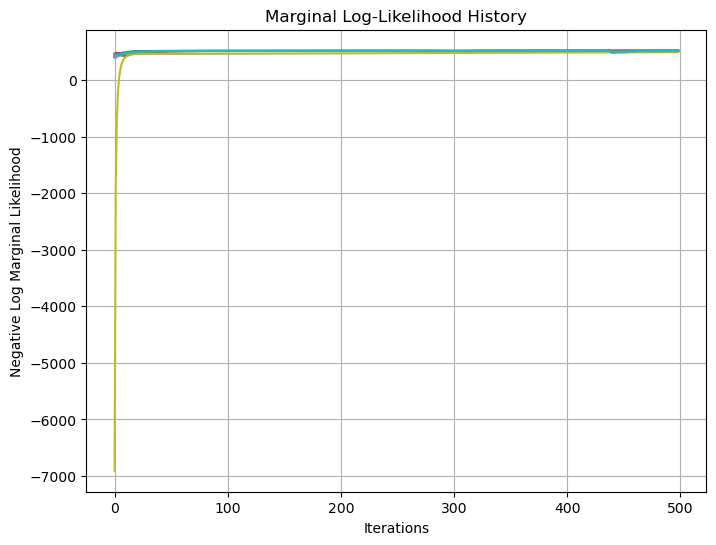

In [41]:
# Plot the log likelihood history for each run (we plot from iteration 1 onwards)
plt.figure(figsize=(8, 6))
plt.plot(res['log_likelihood_history_list'][:,1:].detach().numpy().T)
plt.grid()
plt.xlabel("Iterations")
plt.ylabel("Negative Log Marginal Likelihood")
plt.title("Marginal Log-Likelihood History")
plt.show()

#### Exercise 7 - python skills

In [42]:
# Extracting the index of the max of maximum log likelihood list and the maximum log likelihood
max_log_likelihood_idx = np.array(res['max_log_likelihood_list']).argmax()
max_log_likelihood = res['max_log_likelihood_list'][max_log_likelihood_idx]
print('Index of the maximum log likelihood: {}'.format(max_log_likelihood_idx))
print('Maximum log likelihood: {}'.format(max_log_likelihood))
print('-'*100)

# Extracting the best optimized parameters
optimized_params = res['optim_res_list'][max_log_likelihood_idx]
print('Optimized parameters: {}'.format(optimized_params))

# Computing the predicted values
sum_kernel.set_params(optimized_params)
gp.k = sum_kernel
pred_y = gp.predict(pred_X, data_X, data_y, size=100, sigma=optimized_params['sigma'])

Index of the maximum log likelihood: 7
Maximum log likelihood: 516.773438718172
----------------------------------------------------------------------------------------------------
Optimized parameters: {'sigma': 0.18006232517943863, 'theta1': 79.39127464372059, 'theta10': 1.0531651605504793, 'theta2': 43.833253754294965, 'theta3': 2.1888418416322346, 'theta4': 106.13882043092508, 'theta5': 1.3011091952867353, 'theta6': 0.8610964117067275, 'theta7': 0.28612938218116113, 'theta8': 0.02239982710588304, 'theta9': 0.4495412541502603}


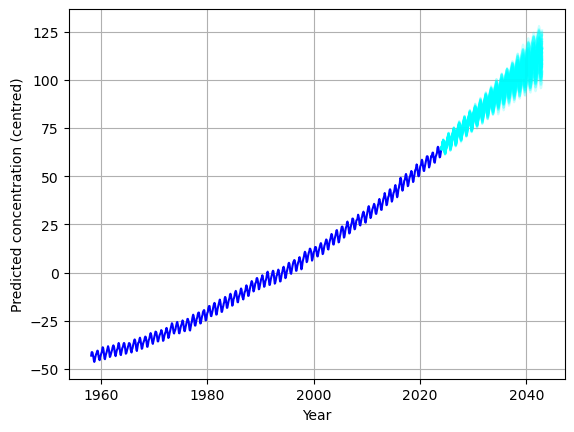

In [43]:
plot_predicted_co2(data_X, data_y, pred_X, pred_y)

**Optional:** In the cell below I want you to plot a figure of subplots (2 rows and 5 columns) where in each plot I can see the evolution of the parameters for each initial values. I.e. in the firt plot I should see `number_of_initial_lists` lines reresenting the update of theta1 in the optimisation loop.

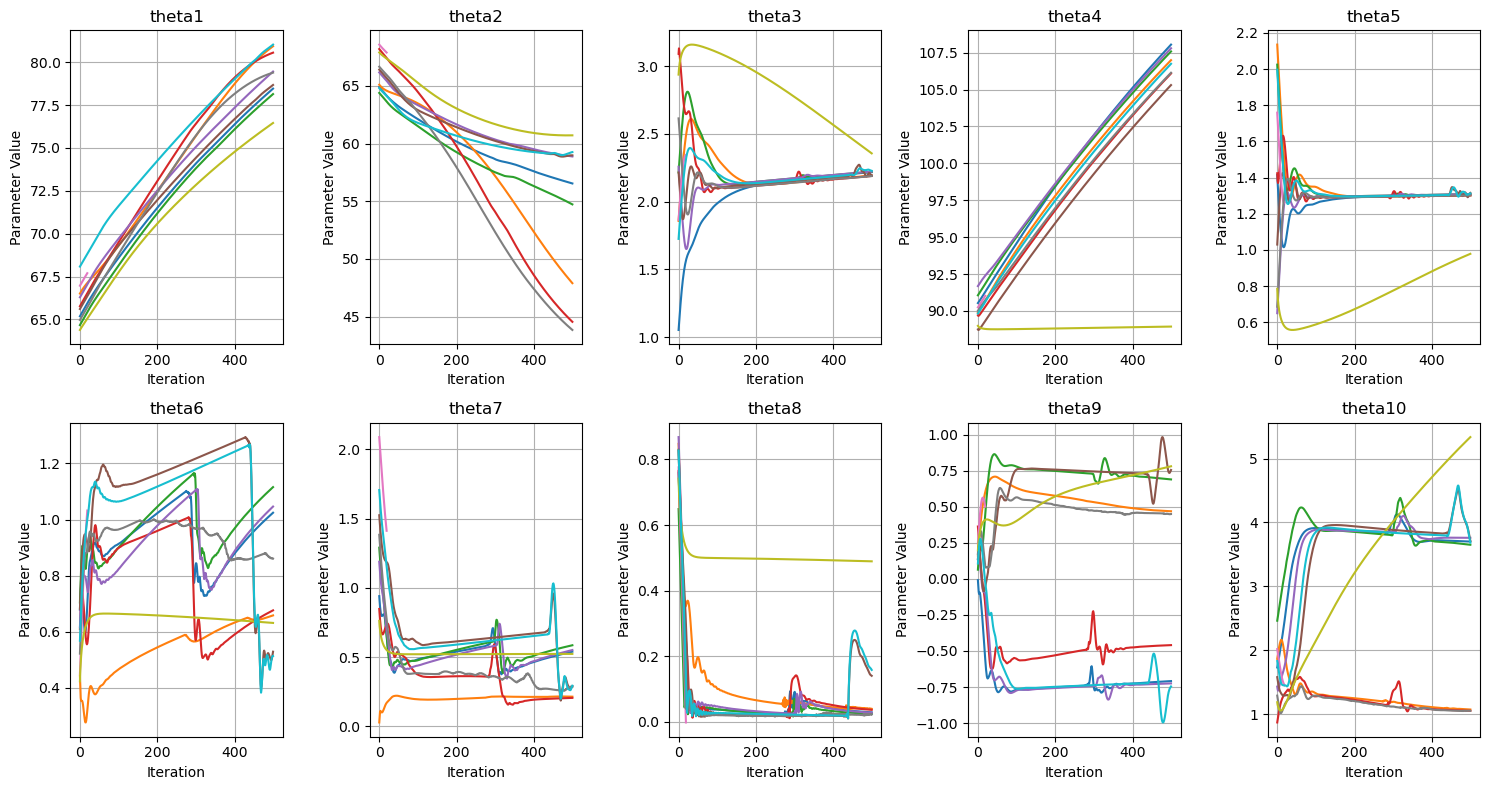

In [44]:
# Create a subplot with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

# Flatten the axes array
axes = axes.flatten()

# Iterate over the parameters
for i in range(number_of_initial_lists):
    # Get the parameter name
    param_name = 'theta{}'.format(i+1)
    
    # Get the parameter history for each run
    param_history = torch.cat([params[param_name].unsqueeze(0) for params in res['params_history_list']], dim=0)
    
    # Plot the parameter history
    axes[i].plot(param_history.numpy().T)
    axes[i].set_title(param_name)
    axes[i].set_xlabel('Iteration')
    axes[i].set_ylabel('Parameter Value')
    axes[i].grid()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


Just to have fun we assess the performance of our model for our kernels individually

iter 1 out of 10
iter 2 out of 10
iter 3 out of 10
iter 4 out of 10
iter 5 out of 10
iter 6 out of 10
iter 7 out of 10
iter 8 out of 10
iter 9 out of 10
iter 10 out of 10
Done!
Index of the maximum log likelihood: 2
Maximum log likelihood: -1048.4075055265962
----------------------------------------------------------------------------------------------------
Optimized parameters: {'sigma': 1.969933997140992, 'theta1': 76.94313583049133, 'theta2': 54.99512245108574}


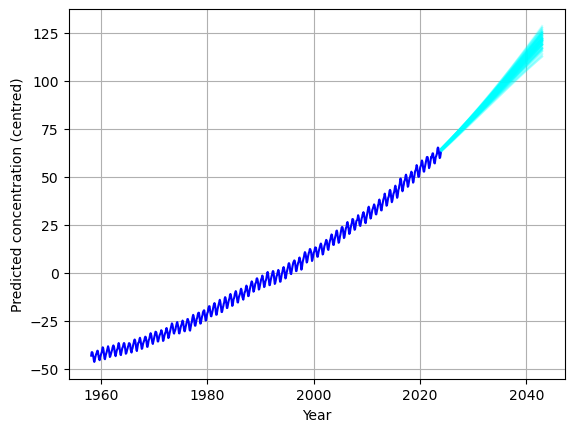

iter 1 out of 10
iter 2 out of 10
iter 3 out of 10
iter 4 out of 10
iter 5 out of 10
iter 6 out of 10
iter 7 out of 10
iter 8 out of 10
iter 9 out of 10
iter 10 out of 10
Done!
Index of the maximum log likelihood: 3
Maximum log likelihood: -546.3176811704321
----------------------------------------------------------------------------------------------------
Optimized parameters: {'sigma': 0.856561478057581, 'theta3': 10.519047692279454, 'theta4': 78.63486187839862, 'theta5': 4.1658700851935135}


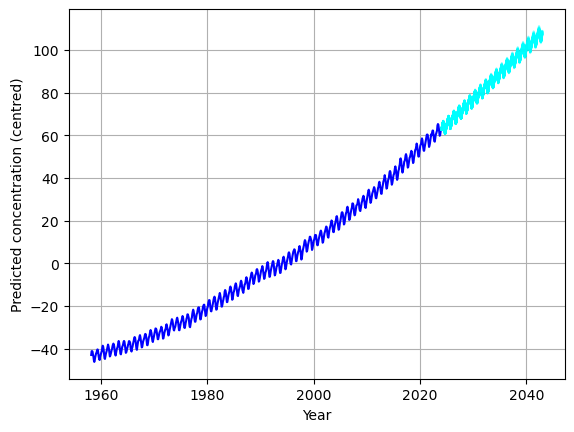

iter 1 out of 10
iter 2 out of 10
iter 3 out of 10
iter 4 out of 10
iter 5 out of 10
iter 6 out of 10
iter 7 out of 10
iter 8 out of 10
iter 9 out of 10
iter 10 out of 10
Done!
Index of the maximum log likelihood: 6
Maximum log likelihood: -814.3465427150766
----------------------------------------------------------------------------------------------------
Optimized parameters: {'sigma': 0.17955658556980944, 'theta6': 3.67888604775215, 'theta7': 0.368176537738471, 'theta8': 0.18402105054082543}


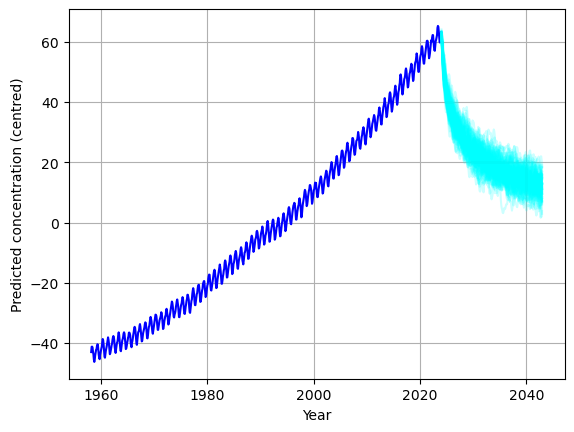

In [37]:
# Initialize the kernels
rbf_kernel = RBF({'theta1': 1., 'theta2': 1.})
periodic_kernel = Periodic({'theta3': 1., 'theta4': 1., 'theta5': 1.})
rational_kernel = RationalQuadratic({'theta6': 1., 'theta7': 1., 'theta8': 1.})

# Initialize the GP models
gp_rbf = GP(kernel=rbf_kernel)
gp_periodic = GP(kernel=periodic_kernel)
gp_rational = GP(kernel=rational_kernel)

# Initialize the initial params list
rbf_initial_params_list = []
for i in range(number_of_initial_lists):
    sample_params_dict = {'theta{}'.format(i+1): z.item() for i, z in enumerate(init_params_list[i,:2])}
    sample_params_dict['sigma'] = init_params_list[i,-1].item()
    rbf_initial_params_list.append(sample_params_dict)

periodic_initial_params_list = []
for i in range(number_of_initial_lists):
    sample_params_dict = {'theta{}'.format(i+3): z.item() for i, z in enumerate(init_params_list[i,2:5])}
    sample_params_dict['sigma'] = init_params_list[i,-1].item()
    periodic_initial_params_list.append(sample_params_dict)

rational_initial_params_list = []
for i in range(number_of_initial_lists):
    sample_params_dict = {'theta{}'.format(i+6): z.item() for i, z in enumerate(init_params_list[i,5:8])}
    sample_params_dict['sigma'] = init_params_list[i,-1].item()
    rational_initial_params_list.append(sample_params_dict)

################ RBF Kernel ################

res_rbf = optim_hyperparams_multiple_runs(rbf_initial_params_list, data_X, data_y, gp_rbf, maxiter=500, learning_rate=0.04)

# Extracting the index of the max of maximum log likelihood list and the maximum log likelihood
max_log_likelihood_idx = np.array(res_rbf['max_log_likelihood_list']).argmax()
max_log_likelihood = res_rbf['max_log_likelihood_list'][max_log_likelihood_idx]
print('Index of the maximum log likelihood: {}'.format(max_log_likelihood_idx))
print('Maximum log likelihood: {}'.format(max_log_likelihood))
print('-'*100)

# Extracting the best optimized parameters
optimized_params_rbf = res_rbf['optim_res_list'][max_log_likelihood_idx]
print('Optimized parameters: {}'.format(optimized_params_rbf))

# Computing the predicted values
gp_rbf.k.set_params(optimized_params_rbf)
pred_y = gp_rbf.predict(pred_X, data_X, data_y, size=100, sigma=optimized_params_rbf['sigma'])
plot_predicted_co2(data_X, data_y, pred_X, pred_y)


################ Periodic Kernel ################

res_periodic = optim_hyperparams_multiple_runs(periodic_initial_params_list, data_X, data_y, gp_periodic, maxiter=500, learning_rate=0.04)

# Extracting the index of the max of maximum log likelihood list and the maximum log likelihood
max_log_likelihood_idx = np.array(res_periodic['max_log_likelihood_list']).argmax()
max_log_likelihood = res_periodic['max_log_likelihood_list'][max_log_likelihood_idx]
print('Index of the maximum log likelihood: {}'.format(max_log_likelihood_idx))
print('Maximum log likelihood: {}'.format(max_log_likelihood))
print('-'*100)

# Extracting the best optimized parameters
optimized_params_periodic = res_periodic['optim_res_list'][max_log_likelihood_idx]
print('Optimized parameters: {}'.format(optimized_params_periodic))

# Computing the predicted values
gp_periodic.k.set_params(optimized_params_periodic)
pred_y = gp_periodic.predict(pred_X, data_X, data_y, size=100, sigma=optimized_params_periodic['sigma'])
plot_predicted_co2(data_X, data_y, pred_X, pred_y)


################ Rational Quadratic Kernel ################

res_rational = optim_hyperparams_multiple_runs(rational_initial_params_list, data_X, data_y, gp_rational, maxiter=500, learning_rate=0.04)

# Extracting the index of the max of maximum log likelihood list and the maximum log likelihood
max_log_likelihood_idx = np.array(res_rational['max_log_likelihood_list']).argmax()
max_log_likelihood = res_rational['max_log_likelihood_list'][max_log_likelihood_idx]
print('Index of the maximum log likelihood: {}'.format(max_log_likelihood_idx))
print('Maximum log likelihood: {}'.format(max_log_likelihood))
print('-'*100)

# Extracting the best optimized parameters
optimized_params_rational = res_rational['optim_res_list'][max_log_likelihood_idx]
print('Optimized parameters: {}'.format(optimized_params_rational))

# Computing the predicted values
gp_rational.k.set_params(optimized_params_rational)
pred_y = gp_rational.predict(pred_X, data_X, data_y, size=100, sigma=optimized_params_rational['sigma'])
plot_predicted_co2(data_X, data_y, pred_X, pred_y)


## Interpretation of Kernel Hyper-Parameters
***

Taking the final parameters
```python
final_params = [15.60917401 37.85666397 51.65420898 41.91108205  6.60621616  0.45302811
  0.54545549 21.92928839 27.86849259 20.36595657 -0.25296079]

```
as an example, we see that:

- The long-term trend has magnitude $\theta_1 \approx 16$ and a length-scale of $\theta_2 \approx 38$ years.

- The periodic contribution has magnitude $\theta_3 \approx 52$, decay-time $\theta_4 \approx 42$ years, and smoothness $\theta_5 \approx 7$. The long decay-time shows that the data has a component that is very close to a seasonal periodicity in the short term.

- The medium/short-term component has magnitude $\theta_6 \approx 0.5$ ppm, length-scale $\theta_7 \approx 0.5$ yearms and shape $\theta_8 \approx 22$.

- The correlated noise term has amplitude $\theta_9 \approx 28$ and lengt-scale $\theta_{10} \approx 20$, and the uncorrelated noise term has magnitude $\theta_{11} \approx 0.3$ (we take the absolute value due to unidentifiability: $\theta_{11}^2 = (-\theta_{11})^2$). The relatively small value of $\theta_{11}$ suggests the uncorrelated noise level is small compared with the signal in the data, and the data have been very well explained by the model.

As mentioned previously, this is only a local optimum and thus only one of many plausible sets of hyper-parameters that can explain the data. Each local optimum will correspond to a different interpretation of these parameters. You are encouraged to play around with the starting points and plot the resulting posterior draws to see how different hyper-parameters can affect the predictions.

***